# Planet OS API Demo for Model Comparison

_Note: this notebook requires python3._

This page demonstrates how the Planet OS API can easily be used to compare data from different models. This method should be used to evaluate model quality, which is a much more comprehensive task and is a duty of model developers. 

For descriptions of the individual models, please refer to the following dataset pages: [GFS](http://data.planetos.com/datasets/noaa_gfs_global_sflux_0.12d:gfs-global-weather-forecast-by-ncep-near-surface-parameters), [HYCOM](http://data.planetos.com/datasets/hycom_glbu0.08_91.1_global_0.08d:hycom-hybrid-coordinate-ocean-model-global-ocean-forecast), [WaveWatch III](http://data.planetos.com/datasets/noaa_ww3_global_1.25x1d:noaa-wave-watch-iii-nww3-ocean-wave-model), [SWAN](http://data.planetos.com/datasets/pacioos_swan_oahu:simulating-waves-nearshore-swan-regional-wave-model-oahu), and [BOM ACCESS-G](http://data.planetos.com/datasets/bom_access-g_global_40km:global-domain-of-the-australian-community-climate-and-earth-system-simulator-access-g-numerical-weather-prediction-nwp-data).

API documentation is available at http://docs.planetos.com. If you have questions or comments, join the [Planet OS Slack community](http://slack.planetos.com) to chat with our development team.

For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
from urllib.request import urlopen, Request
import simplejson as json

In [2]:
def extract_reference_time(API_data_loc):
    """Find reference time that corresponds to most complete forecast. Should be the earliest value."""
    reftimes = set()
    for i in API_data_loc['entries']:
        reftimes.update([i['axes']['reftime']])
    reftimes=list(reftimes)
    if len(reftimes)>1:
        reftime = reftimes[0] if dateutil.parser.parse(reftimes[0])<dateutil.parser.parse(reftimes[1]) else reftimes[1]
    else:
        reftime = reftimes[0]
    return reftime

Let's choose a location near Oahu, Hawaii, to make use of the regional SWAN model we have available...

**Important!** You'll need to replace `apikey` below with your actual Planet OS API key, which you'll find on the [Planet OS account settings page](http://data.planetos.com/account/settings/).

In [3]:
latitude = 21.205
longitude = -158.35
apikey = 'YOUR-API-KEY-GOES-HERE'

At the moment, there is no method to automatically and reliably associate different variable names in each model to one another. Therefore for each model, we give either the variable name or False if the variable is not available.
[Surface temperature, 2m temperature, significant wave height]

In [4]:
datasets = {'noaa_gfs_global_sflux_0.12d':['Temperature_surface','Temperature_height_above_ground',False],
            'bom_access-g_global_40km':['sfc_temp','temp_scrn',False],
            'pacioos_swan_oahu':[False,False,'shgt'],
            'noaa_ww3_global_1.25x1d':[False,False,'Significant_height_of_wind_waves_surface'],
            'hycom_glbu0.08_91.1_global_0.08d':['water_temp',False,False]}

In [5]:
API_data = {}
for i in datasets:
    API_url = "http://api.planetos.com/v1/datasets/{3}/point?lon={0}&lat={1}&count=30000&verbose=false&apikey={2}".format(longitude,latitude,apikey,i)
    request = Request(API_url)
    response = urlopen(request)
    API_data[i] = json.loads(response.read())

For clarity, we extract the data and create a plot for each variable separately...

### Surface Temperature Plot 

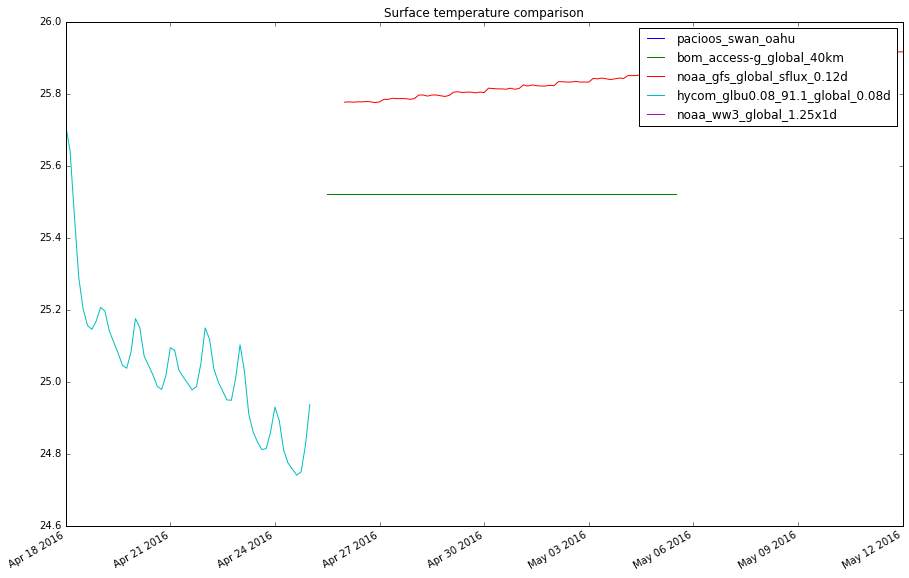

In [6]:
fig = plt.figure(figsize=(15,10))
plt.title('Surface temperature comparison')
ax = fig.add_subplot(111)
for i in datasets:
    time_axes = []
    data_axes = []
    ## API response may give more than one reference time by default, choose only the last full forecast by default
    reftime = extract_reference_time(API_data[i])
    for d in API_data[i]['entries']:
        for j in d['data']:
            if j == datasets[i][0]:
                ## rought method to check if we expect kelvin or celsius
                add_number = d['data'][j] if d['data'][j] < 200. else d['data'][j] -273.15
                if d['axes']['reftime'] == reftime:
                    ## Filter out deeper ocean levels, for HYCOM
                    if 'z' in d['axes']:
                        if d['axes']['z'] < 1.:
                            data_axes.append(add_number)
                            time_axes.append(dateutil.parser.parse(d['axes']['time']))
                    else:
                        data_axes.append(add_number)
                        time_axes.append(dateutil.parser.parse(d['axes']['time']))
    plt.plot(time_axes,data_axes,label=i)
plt.legend()
fig.autofmt_xdate()

### 2m Temperature Plot

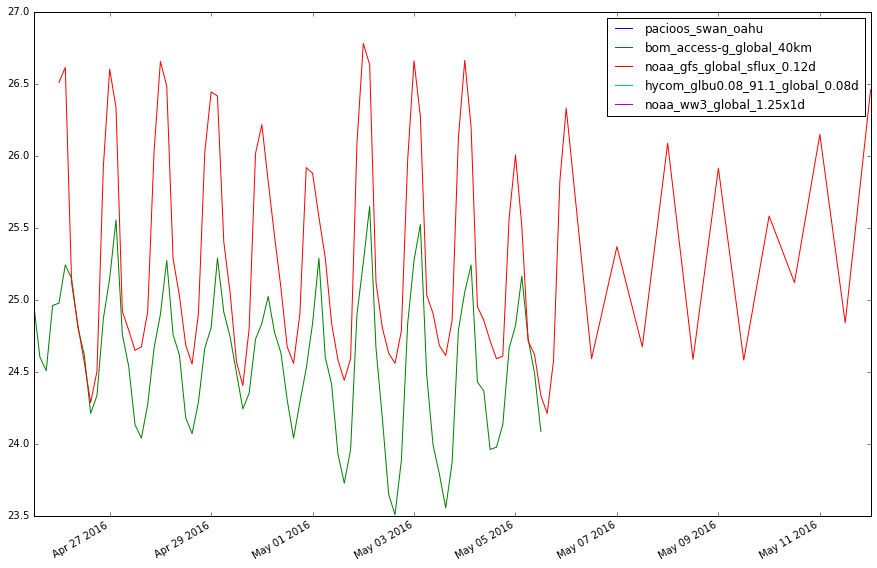

In [7]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in datasets:
    time_axes = []
    data_axes = []
    reftime = extract_reference_time(API_data[i])
    for d in API_data[i]['entries']:
        for j in d['data']:
            if j == datasets[i][1]:
                ## rought method to check if we expect kelvin or celsius
                add_number = d['data'][j] if d['data'][j] < 200. else d['data'][j] -273.15
                if d['axes']['reftime'] == reftime:
                    data_axes.append(add_number)
                    time_axes.append(dateutil.parser.parse(d['axes']['time']))
    plt.plot(time_axes,data_axes,label=i)
plt.legend()
fig.autofmt_xdate()

### Significant Wave Height Plot

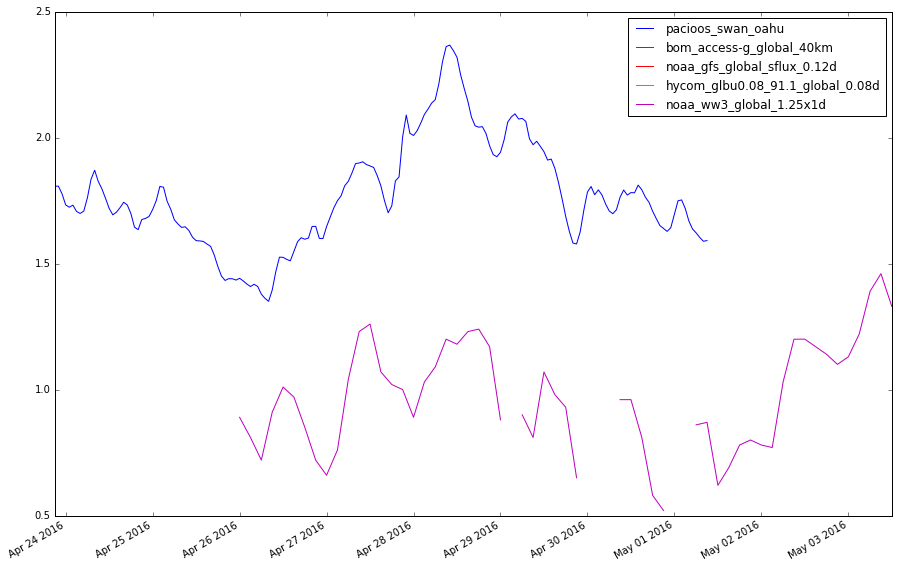

In [8]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i in datasets:
#for i in ['noaa_gfs_global_sflux_0.12d']:
    time_axes = []
    data_axes = []
    for d in API_data[i]['entries']:
        #for k in API_data[d]:
        #    print(k)
        for j in d['data']:
            if j == datasets[i][2]:
                data_axes.append(d['data'][j])
                time_axes.append(dateutil.parser.parse(d['axes']['time']))
    plt.plot(time_axes,data_axes,label=i)
plt.legend()
fig.autofmt_xdate()